more qs:

- why for dry/wet coupling SOM, when the grid size is smaller, the model separates dry and wet cases as dry high anamoly and wet low anamoly only? 

- do i need to look at more than just the leading node for the two cases? 

- try limiting spatial domain 


for donglai:

- does the project description make sense as an application of SOM?

- did i structure my input data correctly for the algorithm? 

- how to choose hyperparameters correctly? limit quantization error, but if its too small, it overfits

- what frequency (how many # of samples/total # of samples) should the leading node have? 

- difference between my result using standardized anamolies and the SOM result? 

- changing BMU figure when using same hyperparameters?


turn down learning rate
try som.train(100 times)

cool paper on SOMs, describing different ways to measure how good the model did: https://digitalcommons.uri.edu/cgi/viewcontent.cgi?article=2013&context=theses

## self organizing maps project description

The goal is to identify the leading patterns of geopotential height for two forms of land-atmosphere feedbacks, dry coupling afternoon precipitation events and wet coupling afternoon precipitation events, in order to determine whether there are large-scale factors which create the preconditions to support these land-surface feedbacks. 

In [1]:
import pandas as pd
import glob
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import os
import re
from datetime import datetime, timedelta
from haversine import haversine, Unit
import metpy
import metpy.constants as mpconst
import metpy.units as units
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
from matplotlib.patches import Rectangle
from pydoc import help
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
with open('geosom.pkl', 'rb') as f:
    
    geosom = pickle.load(f)

#filtering for only dry APE or wet APE cases (160 total cases, 58 wet coupling and 102 dry coupling)

geosom.rename_axis('day', axis='index', inplace=True)

geosom.reset_index(inplace=True)

geosom.rename(columns={'daily_mean': 'z500'}, inplace=True)

#splitting into labels & features, where labels = ape or non-ape and features are geopotential height

labels_df = geosom[['day','APE']].drop_duplicates(keep='first')

labels_df.reset_index(drop=True, inplace=True)

labels = labels_df.iloc[:,1:].values

features = geosom[['day','lat','lon','z500']]

In [7]:
#restructuring features such that there is a unique combination of latitude and longitude as its own column
#so that there is one row for each day 
#latitude range: 25 --> 50, longitude range: 70 --> 120

X_feat = features.pivot_table(index='day', columns=['lat', 'lon'], values=['z500'])

X_feat.reset_index(inplace=True)

#flattening the MultiIndex column names

X_feat.columns = [''.join(map(str, col)) for col in X_feat.columns]

X = X_feat.iloc[:, 1:].values

#after restructuring features into X_feat, combining into a single dataframe for later use
#data has shape 160 x 1329 (160 days, 1329 latitude, longitude pairs)
data = pd.merge(X_feat, labels_df, on='day', how='inner')

In [8]:
# calculated standardized anamolies: x - mean (of feature)/standard deviation (of feature)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [13]:
# hyperparameter options

param_grid = {
    'x': [10, 15, 20],
    'y': [10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'sigma': [0.5, 1.0, 1.5]
}

# all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# initialize variables to track the best configuration
best_params = None

best_quantization_error = float('inf')

# function to calculate quantization error: measures the average distance between each data point and its corresponding BMU in the SOM

def quantization_error(som, data):
    
    error = 0
    
    for x in data:
        
        #difference between x (from x_scaled) and weights for the winning node, then take the norm of that vector to get the total distance
        error += np.linalg.norm(x - som.get_weights()[som.winner(x)])
    
    #for each SOM, calculate the average QE
    return error / len(data)

# # grid search

for params in grid:
    
    som = MiniSom(x=params['x'], y=params['y'], input_len=X_scaled.shape[1], sigma=params['sigma'], learning_rate=params['learning_rate'])
    
    som.random_weights_init(X_scaled)
    
    som.train_random(data=X_scaled, num_iteration=1000)
    
    qe = quantization_error(som, X_scaled)
    
    print(f"Params: {params}, Quantization Error: {qe}")
    
    #best_quantization_error starts at infinity, then with each subsequent QE calculation, updates best QE & params if new QE is less than previous QE 
    
    if qe < best_quantization_error:
        
        best_quantization_error = qe
        
        best_params = params

print(f"Best params: {best_params}, Best Quantization Error: {best_quantization_error}")


Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 10, 'y': 10}, Quantization Error: 18.824645343568385
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 10, 'y': 15}, Quantization Error: 17.54700147148199
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 10, 'y': 20}, Quantization Error: 16.577756975261224
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 15, 'y': 10}, Quantization Error: 17.558276114301034
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 15, 'y': 15}, Quantization Error: 16.101859093213946
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 15, 'y': 20}, Quantization Error: 15.054161317059588
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 20, 'y': 10}, Quantization Error: 16.581363886820824
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 20, 'y': 15}, Quantization Error: 15.09177485497056
Params: {'learning_rate': 0.01, 'sigma': 0.5, 'x': 20, 'y': 20}, Quantization Error: 14.08515947836475
Params: {'learning_rate': 0.01, 'sigma': 1.0, 'x': 10, 'y': 10}, Qu

Params: {'learning_rate': 0.5, 'sigma': 1.5, 'x': 20, 'y': 20}, Quantization Error: 15.472148512887918
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 10, 'y': 10}, Quantization Error: 16.966155873128454
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 10, 'y': 15}, Quantization Error: 16.024657963463262
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 10, 'y': 20}, Quantization Error: 15.38635079987202
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 15, 'y': 10}, Quantization Error: 16.078152565967784
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 15, 'y': 15}, Quantization Error: 15.091644545686167
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 15, 'y': 20}, Quantization Error: 14.083306663401636
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 20, 'y': 10}, Quantization Error: 15.267251044655504
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 20, 'y': 15}, Quantization Error: 14.10627549521585
Params: {'learning_rate': 1, 'sigma': 0.5, 'x': 20, 'y': 20}, Quantization Error: 13.096576

In [42]:
#hyperparameters

np.random.seed(42)

n_rows, n_columns = 15, 20

sigma = 0.5

learning_rate = 1

som = MiniSom(n_rows, n_columns, X_scaled.shape[1], sigma=sigma, learning_rate=learning_rate, random_seed=42)

som.random_weights_init(X_scaled)

som.train_random(X_scaled, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 16.18371809882364


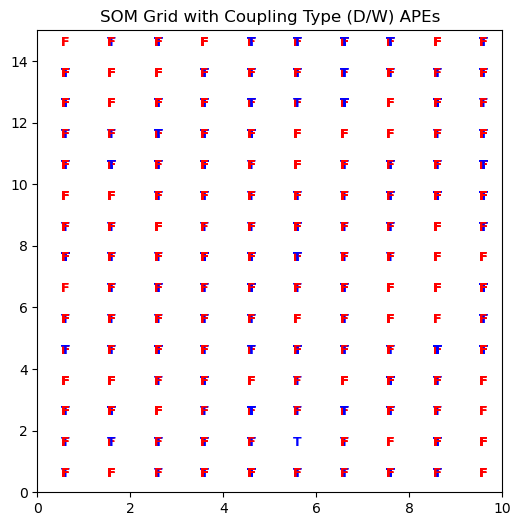

In [47]:
# visualization of trained SOM: does not show frequency in each node, but shows general distribution between dry/wet cases

plt.figure(figsize=(6, 6))

#i = index, x is the vector (all geopotential heights across all locations)

for i, x in enumerate(X_scaled):
    
    w = som.winner(x)
    
    if data['APE'][i] == True: 
        
        binary = 'T'
        
        color = 'b'
    
    elif data['APE'][i] == False:
        
        binary = 'F'
        
        color = 'r'
    
    plt.text(w[0]+0.5, w[1]+0.5, binary, color=color, fontdict={'weight': 'bold', 'size': 9})

plt.xlim([0, som.get_weights().shape[0]])

plt.ylim([0, som.get_weights().shape[1]])

plt.title('SOM Grid with Coupling Type (D/W) APEs')

plt.show()

In [48]:
# extract the BMUs for each data point
bmus = np.array([som.winner(x) for x in X_scaled])

# adding the BMUs to the DataFrame
data['bmu_row'] = bmus[:, 0]

data['bmu_col'] = bmus[:, 1]

#separate dry bmus and wet bmus 
ape_cases = data[(data['APE'] == True)]

nonape_cases = data[(data['APE'] == False)]

ape_bmus = ape_cases[['bmu_row', 'bmu_col']].values

nonape_bmus = nonape_cases[['bmu_row', 'bmu_col']].values

ape_bmu_counts = Counter(map(tuple, ape_bmus))

nonape_bmu_counts = Counter(map(tuple, nonape_bmus))

ape_leading_node, ape_frequency = ape_bmu_counts.most_common(1)[0]
nonape_leading_node, nonape_frequency = nonape_bmu_counts.most_common(1)[0]

print(ape_leading_node, (ape_frequency/ape_cases.shape[0])*100)
print(nonape_leading_node, (nonape_frequency/nonape_cases.shape[0])*100)

(0, 7) 3.081232492997199
(4, 0) 1.9554589896795218


In [49]:
leading_weights_ape = som.get_weights()[ape_leading_node]

leading_weights_nonape = som.get_weights()[nonape_leading_node]

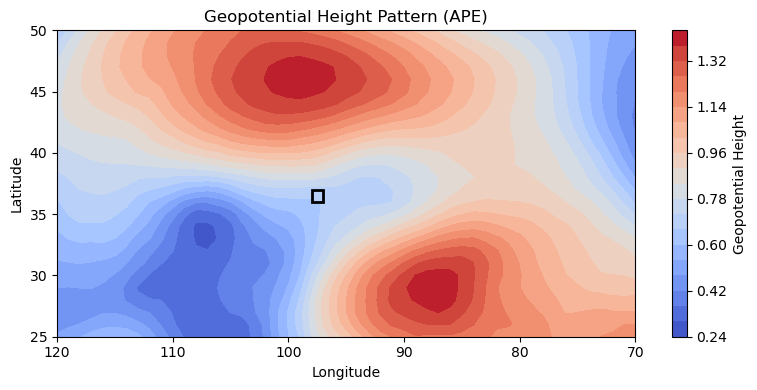

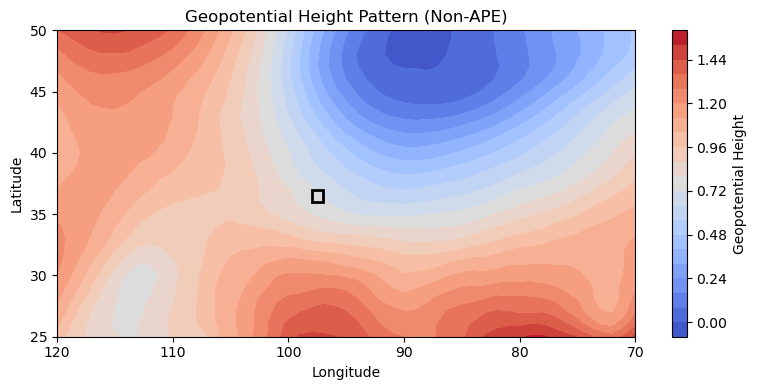

In [50]:
#plotting most frequent node for both dry & wet 

# norm = TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

cmap = plt.get_cmap('coolwarm')

sgp_lon_min, sgp_lon_max = 97, 98

sgp_lat_min, sgp_lat_max = 36, 37

latitude_size = 26  

longitude_size = 51  

geopotential_height_ape = leading_weights_ape.reshape((latitude_size, longitude_size))

geopotential_height_nonape = leading_weights_nonape.reshape((latitude_size, longitude_size))

latitudes = np.linspace(25, 50, latitude_size)

longitudes = np.linspace(70, 120, longitude_size)

lon, lat = np.meshgrid(longitudes, latitudes)

neurons = {
    
    'APE': geopotential_height_ape,
    
    'Non-APE': geopotential_height_nonape
}

for title, geopotential_height in neurons.items():
    
    plt.figure(figsize=(8, 4))

    plt.contourf(lon, lat, geopotential_height, cmap=cmap, levels=20, norm=mcolors.Normalize())

#     plt.contourf(lon, lat, geopotential_height, cmap=cmap, levels=20, norm=norm)
    
    plt.colorbar(label='Geopotential Height')
    
    plt.title(f'Geopotential Height Pattern ({title})')
    
    plt.xlabel('Longitude')
    
    plt.ylabel('Latitude')
    
    plt.gca().invert_xaxis()

    sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, sgp_lat_max - sgp_lat_min,
                        edgecolor='black', facecolor='none', linewidth=2)
    
    plt.gca().add_patch(sgp_box)

    plt.tight_layout()
    
    plt.show()

 Training...
 pca_linear_initialization took: 0.004000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 30

 epoch: 1 ---> elapsed time:  0.006000, quantization error: 1.291679

 epoch: 2 ---> elapsed time:  0.004000, quantization error: 1.219328

 epoch: 3 ---> elapsed time:  0.004000, quantization error: 1.102994

 epoch: 4 ---> elapsed time:  0.004000, quantization error: 1.040977

 epoch: 5 ---> elapsed time:  0.004000, quantization error: 1.012549

 epoch: 6 ---> elapsed time:  0.004000, quantization error: 0.990108

 epoch: 7 ---> elapsed time:  0.004000, quantization error: 0.966662

 epoch: 8 ---> elapsed time:  0.003000, quantization error: 0.948943

 epoch: 9 ---> elapsed time:  0.003000, quantization error: 0.937570

 epoch: 10 ---> elapsed time:  0.004000, quantization error: 0.923310

 epoch: 11 ---> elapsed time:  0.003000, quantization error: 0.907238

 epoch: 12 ---> elapsed time:  0.004000, quantization error: 0.892085

 epoch: 13 --

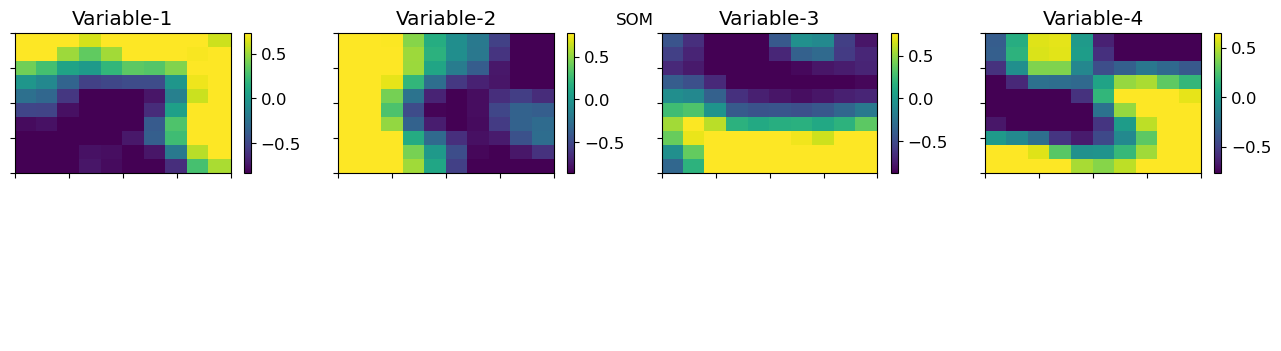

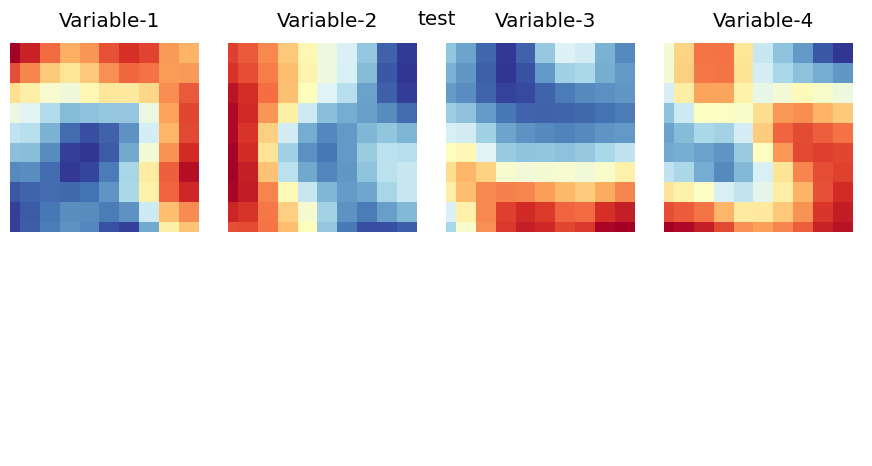

In [55]:
import sompy

data = np.random.rand(100, 4)  # 100 samples with 4 features each
df = pd.DataFrame(data, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4'])

# Initialize the SOM
sm = sompy.SOMFactory().build(df.values, mapsize=[10, 10], normalization='var')

# Train the SOM
sm.train(n_job=1, verbose='info')

# Access the trained SOM components
codebook = sm.codebook.matrix

# Visualize the results
from sompy.visualization.mapview import View2D
view2D = View2D(10, 10, "SOM", text_size=12)
view2D.show(sm, col_sz=4, which_dim="all")

# Alternatively, you can visualize component planes
from sompy.visualization.mapview import View2DPacked
v = View2DPacked(50, 50, 'test', text_size=12)
v.show(sm, which_dim="all", col_sz=4)